<a href="https://colab.research.google.com/github/munazzaz/-Number-Guessing-Game/blob/main/Travel_Planner_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U langchain
%pip install -q -U langgraph
%pip install -q -U langchain-google-genai
%pip install -q -U python-dotenv

In [2]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv

In [3]:
import os
from google.colab import userdata

# Access the GEMINI_API_KE from Colab's Secrets
gemini_api_key = userdata.get("GEMINI_API_KEY")  # Use the correct secret name

# Verify it has been set correctly
print("Gemini API Key set successfully:")

Gemini API Key set successfully:


In [4]:
# class PlannerState(TypedDict):
#     messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
#     city: str
#     interests: List[str]
#     itinerary: str

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    days: int  # New field for the number of days
    itineraries: List[str]  # New field for storing multiple itineraries


In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = gemini_api_key)
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a detailed day-by-day itinerary for {city} over {days} days based on the user's interests: {interests}. The itinerary should include specific recommendations for activities, places to visit, and dining options."),
    ("human", "Create an itinerary for my day trip."),
])

In [17]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip:")
    user_message = input("Your input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def input_interests(state: PlannerState) -> PlannerState:
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(',')],
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def input_days(state: PlannerState) -> PlannerState:
    print(f"How many days do you plan to stay in {state['city']}?")
    user_message = input("Your input: ")
    days = int(user_message)  # Convert input to integer
    return {
        **state,
        "days": days,
        "messages": state['messages'] + [HumanMessage(content=f"{days} days")],
        "itineraries": []  # Initialize an empty list for itineraries
    }

# def create_itinerary(state: PlannerState) -> PlannerState:
#     print(f"Creating itineraries for {state['city']} over {state['days']} days based on interests: {', '.join(state['interests'])}...")

#     for day in range(1, state['days'] + 1):
#         response = llm.invoke(itinerary_prompt.format_messages(
#             city=state['city'],
#             interests=", ".join(state['interests']),
#             days=state['days']
#         ))
#         print(f"\nDay {day} Itinerary:")
#         print(response.content)
#         state['itineraries'].append(f"Day {day}:\n{response.content}")

#     return {
#         **state,
#         "messages": state['messages'] + [AIMessage(content="\n".join(state['itineraries']))]
#     }

def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating itineraries for {state['city']} over {state['days']} days based on interests: {', '.join(state['interests'])}...")

    for day in range(1, state['days'] + 1):
        response = llm.invoke(itinerary_prompt.format_messages(
            city=state['city'],
            interests=", ".join(state['interests']),
            days=state['days'],
            budget=state.get('budget', 'moderate')  # Default to 'moderate'
        ))
        print(f"\nDay {day} Itinerary:")
        print(response.content)
        state['itineraries'].append(f"Day {day}:\n{response.content}")

    return {
        **state,
        "messages": state['messages'] + [AIMessage(content="\n".join(state['itineraries']))]
    }

# def create_itinerary(state: PlannerState) -> PlannerState:
#     print(f"Creating itineraries for {state['city']} over {state['days']} days based on interests: {', '.join(state['interests'])}...")

#     for day in range(1, state['days'] + 1):
#         response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
#         print(f"\nDay {day} Itinerary:")
#         print(response.content)
#         state['itineraries'].append(f"Day {day}:\n{response.content}")

#     return {
#         **state,
#         "messages": state['messages'] + [AIMessage(content="\n".join(state['itineraries']))]
#     }

In [18]:
# workflow = StateGraph(PlannerState)

# workflow.add_node("input_city", input_city)
# workflow.add_node("input_interests", input_interests)
# workflow.add_node("create_itinerary", create_itinerary)
# workflow.add_node("input_days", input_days)
# workflow.add_node("input_budget", input_budget)

# workflow.set_entry_point("input_city")

# workflow.add_edge("input_city", "input_days")  # After city input, ask for number of days
# workflow.add_edge("input_days", "input_interests")  # Then ask for interests
# workflow.add_edge("input_interests", "input_budget")  # Then ask for budget
# workflow.add_edge("input_budget", "create_itinerary")  # Then generate the itinerary
# workflow.add_edge("create_itinerary", END)  # End after itinerary creation


workflow = StateGraph(PlannerState)

# Define each state (input functions)
workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)
workflow.add_node("input_days", input_days)
# workflow.add_node("input_budget", input_budget)  # Uncomment if budget step is needed

# Set the entry point
workflow.set_entry_point("input_city")

# Define workflow transitions
workflow.add_edge("input_city", "input_days")          # After city input, ask for number of days
workflow.add_edge("input_days", "input_interests")     # Then ask for interests
workflow.add_edge("input_interests", "create_itinerary")  # Finally, generate the itinerary
# workflow.add_edge("input_interests", "input_budget")  # If budget is included
# workflow.add_edge("input_budget", "create_itinerary")  # Then generate the itinerary

# End workflow after itinerary creation
workflow.add_edge("create_itinerary", END)

# Compile the workflow
app = workflow.compile()



# workflow = StateGraph(PlannerState)

# workflow.add_node("input_city", input_city)
# workflow.add_node("input_interests", input_interests)
# workflow.add_node("create_itinerary", create_itinerary)
# workflow.add_node("input_days", input_days)
# # workflow.add_node("input_budget", input_budget)

# workflow.set_entry_point("input_city")

# workflow.add_edge("input_city", "input_days")  # After city input, ask for number of days
# workflow.add_edge("input_days", "input_interests")  # Then ask for interests
# workflow.add_edge("input_interests", "create_itinerary")  # Finally, generate the itinerary
# # Modify the flow to include the budget input
# # workflow.add_edge("input_interests", "input_budget")  # After interests, ask for budget
# # workflow.add_edge("input_budget", "create_itinerary")  # Then generate the itinerary
# # workflow.add_edge("create_itinerary", END)  # End after itinerary creation
# workflow.add_edge("input_city", "input_interests")
# workflow.add_edge("input_interests", "create_itinerary")
# workflow.add_edge("create_itinerary", END)

# app = workflow.compile()

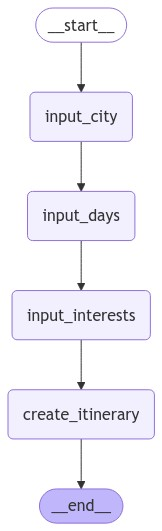

In [19]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [20]:
# def run_travel_planner(user_request: str):
#     print(f"Initial Request: {user_request}\n")
#     state = {
#         "messages": [HumanMessage(content=user_request)],
#         "city": "",
#         "interests": [],
#         "itinerary": "",
#     }

#     for output in app.stream(state):
#         pass  # The nodes themselves now handle all printing

def run_travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "days": 0,  # Initialize days
        "itineraries": []  # Initialize an empty list for itineraries
    }

    for output in app.stream(state):
        pass  # The nodes handle the printing

In [24]:
user_request = "I want to plan a day trip. Guide me through it"
run_travel_planner(user_request)

Initial Request: I want to plan a day trip. Guide me through it

Please enter the city you want to visit for your day trip:
Your input: Rome
How many days do you plan to stay in Rome?
Your input: 2
Please enter your interests for the trip to Rome (comma-separated):
Your input: italian cuisine
Creating itineraries for Rome over 2 days based on interests: italian cuisine...

Day 1 Itinerary:
## Rome: A Foodie's Paradise - 2-Day Itinerary

This itinerary focuses on immersing yourself in the vibrant Italian culinary scene, exploring iconic landmarks, and indulging in authentic flavors.

**Day 1: Traditional Flavors & Hidden Gems**

**Morning:**

* **9:00 AM:** Start your day with a hearty breakfast at **Roscioli Caffè e Pasticceria** (Via dei Giubbonari, 21). Indulge in their famous ricotta and fig jam pastries, or try the traditional Roman breakfast of coffee and maritozzi (sweet bread rolls).
* **10:00 AM:** Walk to the **Trastevere** neighborhood, a charming area with cobbled streets, c